## The model

Consider the following modification to the heat equation:

$$
\frac{\partial T}{\partial t} = \frac{\partial}{\partial z} \bigg(\kappa \frac{\partial T}{\partial z}\bigg) + \bigg(\frac{Q(t)}{\rho_0 c_p z_m} - \gamma\big(T - (T_i(z) + T_0(t))\big) \bigg) \times H(z_m - z) - \mu \big(T - T_i(z) \big) \times H(z - z_d) + \text{C.A.},$$ 

where $T = T(t, z)$ is the temperature (MAKE A NOTE OF WHETHER WE THINK OF THIS AS POTENTIAL, CONSERVATIVE, IN SITU, ETC.); $\kappa$ is the (constant) diffusivity; $Q(t)$ is a prescribed, time-dependent surface heat flux; $\rho_0 = 1025$ kg m$^{-3}$ is the reference density; $c_p = 4000$ J/(kg C) is the specific heat capacity; $z_m$ is the depth of the mix*ing* layer (i.e., a minimum mixed layer); $\gamma$ is a damping term (acting like a climate feedback parameter) which acts to restore the surface back to some initial state $T_i(z)$. The term $T_0$ is applied in perturbations to perturb the surface temperature (like an air temperature perturbation). The $H$ represents a Heaviside function to denote that this forcing and restoring is applied over the minimum mixing layer. The next term is a deep ocean restoring term which acts to balance the surface restoring at the surface. This is so that the steady-state solution is not simply a profile of constant temperature equal to the surface temperature. The paramater $\mu$ is a characteristic timescale over which the temperature profile is relaxed back to its initial profile $T_i(z)$ in the deep ocean (e.g., 20 years), applied only below some prescribed depth $z_d$ (e.g., $z_d = 900$m).

Finally, the term 'C.A.' denotes a convective adjustment algorithm, following _Rahmstorf (1993)_, which checks at each timestep whether any convective instabilities arise and removes them conservatively.

_Make a note of the initial and boundary conditions._

We will write a forward-time, central-space finite difference scheme for this initial-boundary value problem. I have also solved analytically for the steady-state solution, which can be found in an Appendeix to the thesis.

In [6]:
# Constants, data, parameters...

rho = 1035 # kg/m^3
c = 4000 # J/(kg C)

z_m = 25.0 # Depth of minimum mixing layer
z_d = 900.0 # Depth for deep ocean restoring term
z_b = 1000.0 # Depth of thermocline

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
kappa = 5e-06
mu = 1/(5 * 365 * 86400)

T_0 = 22.0 # Top temperature for initial condition
T_b = 5.0 # Bottom temperature for initial condition (this warms up a bit during runs because of the no-flux at bottom condition)

dt = 2.0 * 86400 # units: s
dz = 5.0 # units: m

z = np.linspace(0.0, z_b, int(z_b / dz) + 1) # Depth at top/bottom of grid cell
z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell


# Initial condition: constant in mixing layer, linearly stratified elsewhere

def initial_condition(z_t):
    mixing_index = (np.abs(z_t - z_m)).argmin() # Index in z_t exactly dz/2 m above z_m.
    mixing_layer = T_0 * np.ones(mixing_index + 1)
    z_t = z_t[mixing_index + 1:]
    thermocline = ((T_0 - T_b) * z_t - (T_0 * z_b - T_b * z_m)) / (z_m - z_b)
    return np.concatenate((mixing_layer, thermocline), axis = None)

T_i = initial_condition(z_t)

# Analytical steady state, cf. Appendix B

def steady_state(Z):
    
    # Paramaters
    A = (1 + np.exp(2 * np.sqrt(mu / kappa) * (z_b - z_d))) * np.exp(np.sqrt(mu / kappa) * z_d)
    
    B = (T_0 - T_b) / (z_m - z_b) * (z_m - z_d - np.sqrt(kappa / mu) * np.exp(np.sqrt(mu / kappa) * (z_b - z_d)))
    
    C = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (z_d - z_m) \
    + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa))
    
    D = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    E = (T_0 - T_b) / (z_m - z_b) * (1 - np.exp((z_b - z_d) * np.sqrt(mu / kappa)))
    
    F = np.sqrt(mu / kappa) * (1 - np.exp(2 * (z_b - z_d) * np.sqrt(mu / kappa))) * np.exp(z_d * np.sqrt(mu / kappa))
    
    # Coefficients
    a_1 = (A * E + B * F) / (A * D - C * F)
    
    c_1 = (C * E + B * D) / (A * D - C * F)
    
    # Piecewise defined function (ie, need to use vectorise):
    if Z <= z_m:
        
        return T_0 + a_1 * (np.exp(Z * np.sqrt(gamma / kappa)) + np.exp( - Z * np.sqrt(gamma / kappa)))
    
    elif Z > z_m and Z < z_d:
        
        return T_0 + a_1 * (np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (Z - z_m) \
                            + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    else:
        
        return ((T_0 - T_b) * Z + z_m * T_b - z_b * T_0) / (z_m - z_b) \
    + c_1 * (1 + np.exp(2 * (z_b - Z) * np.sqrt(mu / kappa))) * np.exp(Z * np.sqrt(mu / kappa)) \
    + np.sqrt(kappa / mu) * (T_0 - T_b) / (z_m - z_b) * np.exp((z_b - Z) * np.sqrt(mu / kappa))
    
v_ss = np.vectorize(steady_state)
steady = v_ss(z_t)


### Intermediate functions

def convective_adjustment(T, z_m):
        
    def mixing_Rahmstorf(T):
        
        for i in range(len(T) - 1):
            
            if T[i] < T[i + 1]:
                
                j = 0
                
                # This loop mixes the instability downwards
                
                while T[i + j] < T[i + j + 1]:
                    
                    T[i : i + j + 2] = np.mean(T[i : i + j + 2])
                    
                    j += 1
                    
                break
            
        return T
    
    
    # Run the Rahmstorf mixing algorithm until the instability has been eliminated from the water column (i.e., from the mixing layer) 
    
    for k in range(int(z_m / dz) + 1):
        
        mixing_Rahmstorf(T)
    
    return mixing_Rahmstorf(T)



### Ocean heat content

def OHC(T):
    
    OHC = np.empty(T.shape[1])
    
    for i in range(len(OHC)):
        
        ACCESS_ave_depth = 3645
        
        #OHC[i] = rho * c * np.cumsum(T[: , i])[- 1] * dz # This is for ocean heat content
        
        OHC[i] = z_b / ACCESS_ave_depth * np.mean(T[:, i]) # This is for average temperature
        
    return OHC 




### The forward-in-time, central-in-space scheme with restoring and flux boundary conditions ###

def model(dt, dz, z_m, z_d, z_b, kappa, lambd, T_initial, Q, T0, years):
    
    # Data
    days = dt / 86400 # Timestep in days
    M = int(z_b / dz) # Number of spatial steps evaluated at the top/bottom of the grid cell
    N = int(years * 360 / days) # Number of timesteps in days (taking 1 year = 360 days)
    z = np.linspace(0.0, z_b, M + 1) # Depth at top/bottom of grid cell
    z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell 
    t = np.linspace(0.0, years * 360, N + 1)
    Hdeep = np.heaviside(z - z_d, 1) # 1 below z = z_d, 0 elsewhere
    Hmix = np.heaviside(z_m - z, 0) # 1 above z = z_m, 0 elsewhere
    radiative_forcing = Q / (c * rho * z_m)
    
    # Temperature and flux matrices. Prescribe initial and boundary conditions
    T = np.zeros((M, N + 1)) # i.e. evaluated at the middle of grid cell
    F = np.zeros((M + 1, N + 1)) # i.e. evaluated at the top/bottom of grid cell
    
    T[:, 0] = T_initial # Initial condition
    F[0, :] = 0 # No flux at surface
    F[- 1, :] = 0 # No flux at base
        
    for n in range(0, N):
    
        for m in range(1, M):
            
            F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
        for m in range(0, M):
             
            #NB: T_i = T_i(z), the initial profile
            
            T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) \
            + dt * (radiative_forcing[n] - gamma * (T[m, n] - (T0[n] + T_i[m]))) * Hmix[m]  \
            - dt * mu * (T[m, n] - T_i[m]) * Hdeep[m]

        #Convective adjustment step
    
        convective_adjustment(T[:, n + 1], z_m)
        
    return T

### Define forcings

In [9]:
years = 100
days = dt / 86400
M = int(z_b / dz)
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

def sin(amp, period):
    period_day = period * 360
    return amp * np.sin((2 * np.pi / period_day) * t)



def rolling_mean(array, period):
    window_size = int(period * 360 / (dt / 86400))
                      
    i = 0
    moving_averages = []
    while i < len(array) - window_size + 1:
        this_window = array[i : i + window_size]

        window_average = np.mean(this_window)
        moving_averages.append(window_average)
        i += 1
                      
    return np.array(moving_averages)

### Run model for lots of different periods and amplitudes

In [33]:
years = 100
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
kappa = 5e-06 ### NOTE: NEED TO CHANGE THE STEADY STATE IF CHANGING DIFFUSIVITY
mu = 1/(5 * 365 * 86400)

# Control

Q_cont = np.zeros(int(years * 360 / days) + 1)
T0_cont = np.zeros(int(years * 360 / days) + 1)
T_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_cont, T0_cont, years)

# Variable forcing

#periods = np.array([2, 5, 10, 20])
periods = np.concatenate((np.arange(0.5, 1, 0.1), np.linspace(1,50,50)))
#periods = np.concatenate((np.arange(0.5, 3, 0.1), np.arange(3,10+0.5,0.5)))
Q = 8
T0 = 1.0

T_sinusoids = np.zeros(shape = (M, N+1, periods.shape[0]))
for p in range(len(periods)):
    T_sinusoids[:, :, p] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, sin(Q, periods[p]), sin(T0, periods[p]), years)
    
# T_x2_sinusoids = np.zeros(shape = (M, N+1, periods.shape[0]))
# for p in range(len(periods)):
#     T_x2_sinusoids[:, :, p] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, sin(2 * Q, periods[p]), sin(2 * T0, periods[p]), years)

# T_x3_sinusoids = np.zeros(shape = (M, N+1, periods.shape[0]))
# for p in range(len(periods)):
#     T_x3_sinusoids[:, :, p] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, sin(3 * Q, periods[p]), sin(3 * T0, periods[p]), years)

In [35]:
def final_temp_distribution(periodic_temps, temp_cont):
    return np.array([rolling_mean(OHC(periodic_temps[:,:,i] - temp_cont), periods[i])[-1] for i in range(len(periods))])

T_final_distribution = final_temp_distribution(T_sinusoids, T_cont)
# T_x2_final_distribution = final_temp_distribution(T_x2_sinusoids, T_cont)
# T_x3_final_distribution = final_temp_distribution(T_x3_sinusoids, T_cont)

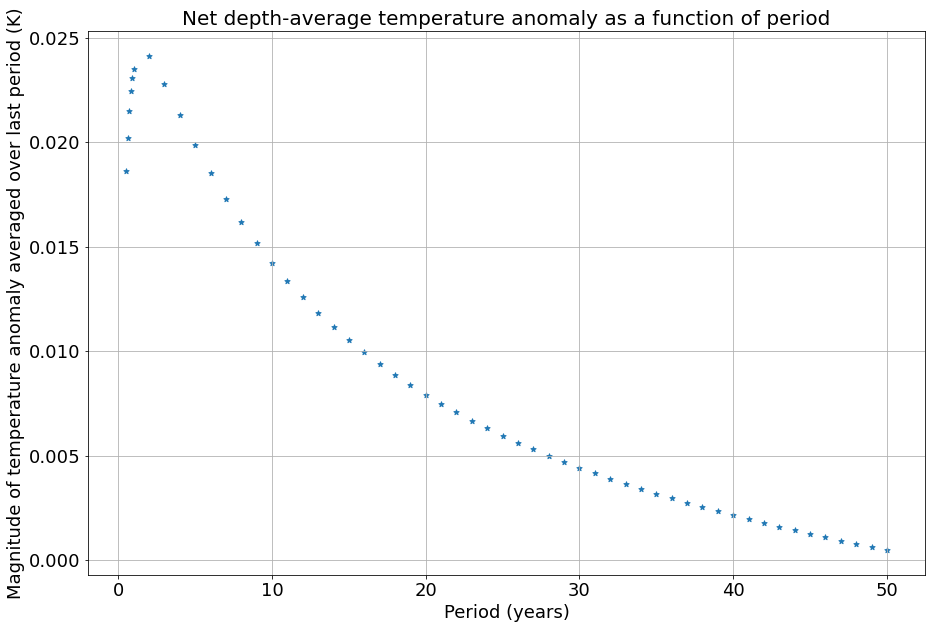

In [37]:
plt.figure(figsize=(15,10))
plt.title('Net depth-average temperature anomaly as a function of period', fontsize=20)
plt.xlabel('Period (years)', fontsize=18)
plt.ylabel('Magnitude of temperature anomaly averaged over last period (K)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.scatter(periods, np.abs(T_final_distribution), s=30, marker='*', color='C0', label='1 x')
# plt.scatter(periods, 1 / 2 * np.abs(T_x2_final_distribution), s=30, marker='*', color='C1', label='$\\frac{1}{2}$ * 2 x')
# plt.scatter(periods, 1 / 3 * np.abs(T_x3_final_distribution), s=30, marker='*', color='C2', label='$\\frac{1}{3}$ * 3 x')
plt.grid()
#plt.legend(fontsize=18)
plt.savefig('ch4_period_1_final_temp_distribution.jpg', bbox_inches='tight', dpi=100)

In [16]:
test = OHC(T_sinusoids[:,:,0] - T_cont)

da = xr.DataArray(data=test, coords=dict(time=time_years))

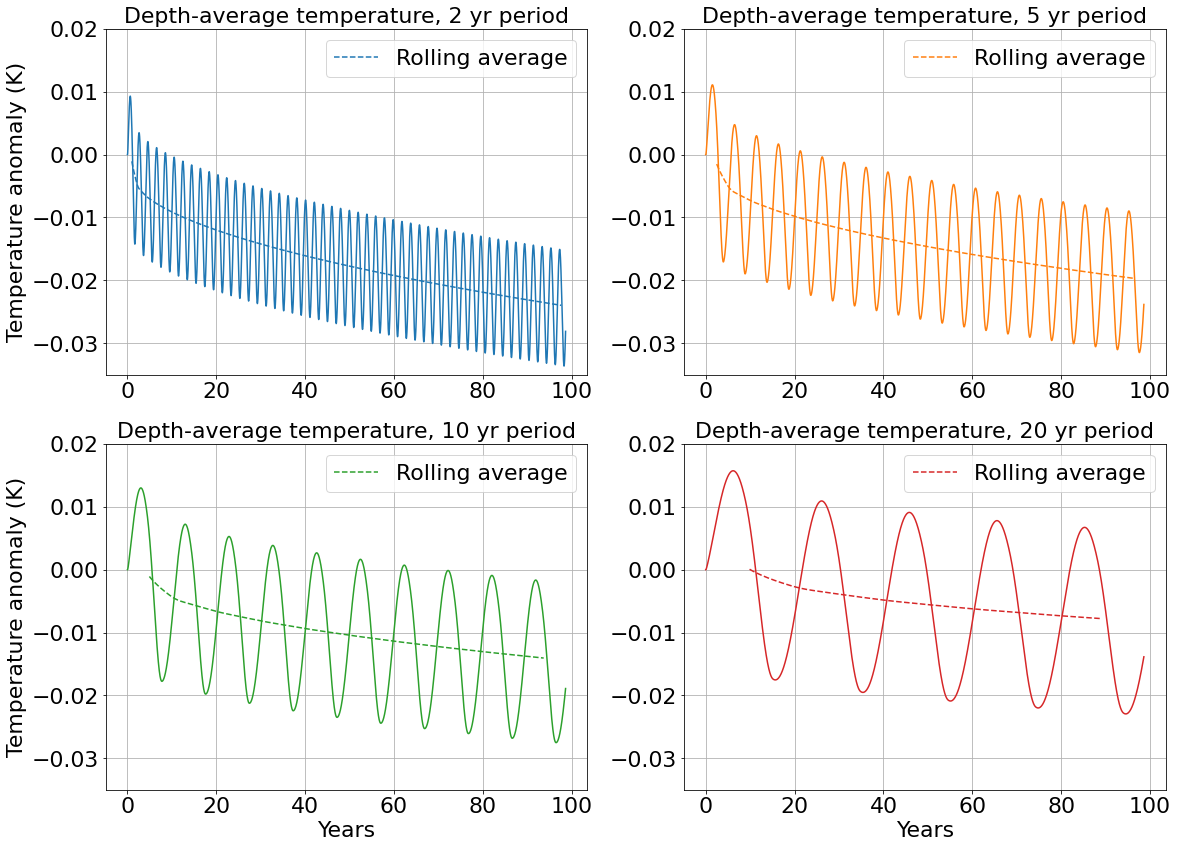

In [13]:
days = dt / 86400
timesteps = T_cont.shape[1]
length = (timesteps - 1) * days / 365 
time_years = np.linspace(0, length, timesteps)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize = (19, 14))
names = ['Depth-average temperature, 2 yr period', 'Depth-average temperature, 5 yr period', 'Depth-average temperature, 10 yr period', 'Depth-average temperature, 20 yr period']
#sinusoids_to_plot = [T_sinusoids[:,:,6], T_sinusoids[:,:,9], T_sinusoids[:,:,14], T_sinusoids[:,:,24]]
#rolling_means_to_plot = [rolling_mean(OHC(periodic_temps[:,:,i] - temp_cont), periods[i]) for i in range(len(periods))]
colors = ['C0', 'C1', 'C2', 'C3']

ymax = 0.02
ymin = -0.035

for i, ax in enumerate(axs.flatten()):
    average_temp = xr.DataArray(data = OHC(T_sinusoids[:,:,i] - T_cont), coords=dict(time=time_years))
    rolling_mean_temp = (average_temp).rolling(time = int(periods[i] * 360 / (dt / 86400)), center=True).mean().dropna('time')
    
    average_temp.plot(ax = ax, color = colors[i])
    rolling_mean_temp.plot(ax = ax, color = colors[i], linestyle = '--', label='Rolling average')

    ax.set_title(names[i], fontsize=22)
    ax.set_xlabel('', fontsize=22)
    ax.set_ylabel('', fontsize=22)
    ax.tick_params(labelsize=22)
    ax.grid()
    ax.legend(fontsize=22)
    ax.set_ylim(ymin, ymax)

axs[0,0].set_ylabel('Temperature anomaly (K)', fontsize=22)
axs[1,0].set_ylabel('Temperature anomaly (K)', fontsize=22)
axs[1,0].set_xlabel('Years', fontsize=22)
axs[1,1].set_xlabel('Years', fontsize=22)
    
# plt.savefig('ch4_1D_four_sinusoids_GAT.jpg', bbox_inches='tight', dpi=100)

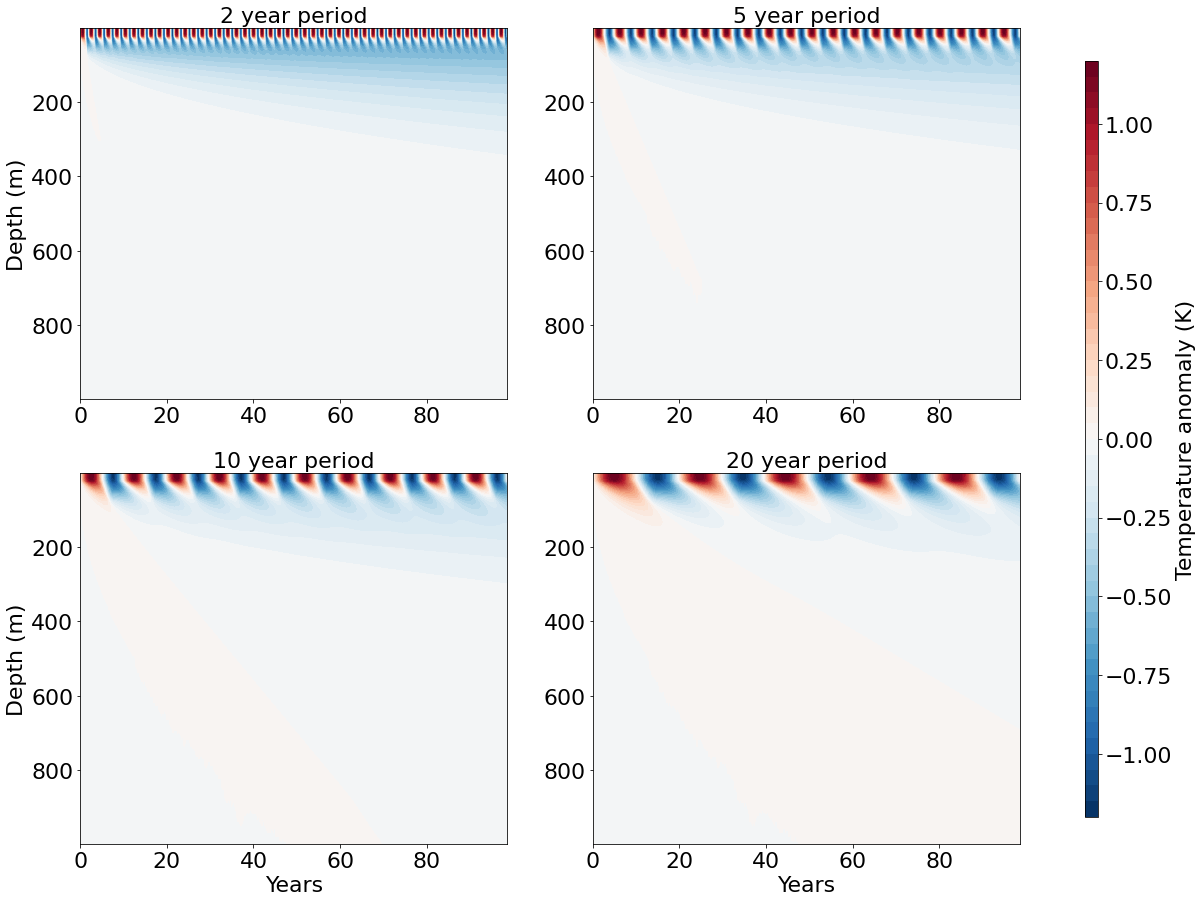

In [20]:
### Hovmoller plot

days = dt / 86400
timesteps = T_cont.shape[1]
length = (timesteps - 1) * days / 365 
time_years = np.linspace(0, length, timesteps)

tt, zz = np.meshgrid(time_years, z_t)
cmap = 'RdBu_r'

fig, axs = plt.subplots(ncols=2, nrows=2, figsize = (18, 15))
names = ['2 year period', '5 year period', '10 year period', '20 year period']
#sinusoids_to_plot = [T_sinusoids[:,:,6], T_sinusoids[:,:,9], T_sinusoids[:,:,14], T_sinusoids[:,:,24]]

for i, ax in enumerate(axs.flatten()):
    ax.set_title(names[i], fontsize=22)
    ax.set_xlabel('', fontsize=22)
    ax.set_ylabel('', fontsize=22)
    ax.tick_params(labelsize=22)
    ax.invert_yaxis()
    im = ax.contourf(tt, zz, T_sinusoids[:,:,i] - T_cont, levels=51, cmap=cmap, norm=TwoSlopeNorm(0)) 

axs[0,0].set_ylabel('Depth (m)', fontsize=22)
axs[1,0].set_ylabel('Depth (m)', fontsize=22)
axs[1,0].set_xlabel('Years', fontsize=22)
axs[1,1].set_xlabel('Years', fontsize=22)    
    
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.01, 0.7]) # left bottom width height
cbar = plt.colorbar(im, cax = cbar_ax)
cbar.set_label(label='Temperature anomaly (K)', size=22)
cbar.ax.tick_params(labelsize=22)

plt.savefig('ch4_1D_four_sinusoids_hovmoller.jpg', bbox_inches='tight', dpi=100)

### Run model with 1 x sinusoidal for lots of periods with different diffusivities

In [17]:
years = 100
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
mu = 1/(5 * 365 * 86400)

# periods = np.array([2, 5, 10, 20])
# periods = np.concatenate((np.arange(0.5, 1, 0.1), np.linspace(1,50,50)))
periods = np.concatenate((np.arange(0.5, 3, 0.1), np.arange(3,10+0.5,0.5)))
Q = 8
T0 = 1.0

Q_cont = np.zeros(int(years * 360 / days) + 1)
T0_cont = np.zeros(int(years * 360 / days) + 1)

## Normal kappa

kappa = 5e-06
v_ss = np.vectorize(steady_state)
steady = v_ss(z_t)
T_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_cont, T0_cont, years)
T_sinusoids = np.zeros(shape = (M, N+1, periods.shape[0]))
for p in range(len(periods)):
    T_sinusoids[:, :, p] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, sin(Q, periods[p]), sin(T0, periods[p]), years)

### Larger kappa

kappa = 1e-5
v_ss = np.vectorize(steady_state)
steady = v_ss(z_t)
T_cont_kappa_plus = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_cont, T0_cont, years)
T_kappa_plus_sinusoids = np.zeros(shape = (M, N+1, periods.shape[0]))
for p in range(len(periods)):
    T_kappa_plus_sinusoids[:, :, p] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, sin(Q, periods[p]), sin(T0, periods[p]), years)

### Smaller kappa

kappa = 1e-6
v_ss = np.vectorize(steady_state)
steady = v_ss(z_t)
T_cont_kappa_minus = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_cont, T0_cont, years)
T_kappa_minus_sinusoids = np.zeros(shape = (M, N+1, periods.shape[0]))
for p in range(len(periods)):
    T_kappa_minus_sinusoids[:, :, p] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, sin(Q, periods[p]), sin(T0, periods[p]), years)

In [29]:
periods = np.concatenate((np.arange(0.5, 3, 0.1), np.arange(3,10+0.5,0.5)))

In [30]:
T_kappa_plus_final_distribution = final_temp_distribution(T_kappa_plus_sinusoids, T_cont_kappa_plus)
T_kappa_minus_final_distribution = final_temp_distribution(T_kappa_minus_sinusoids, T_cont_kappa_minus)
T_final_distribution = final_temp_distribution(T_sinusoids, T_cont)

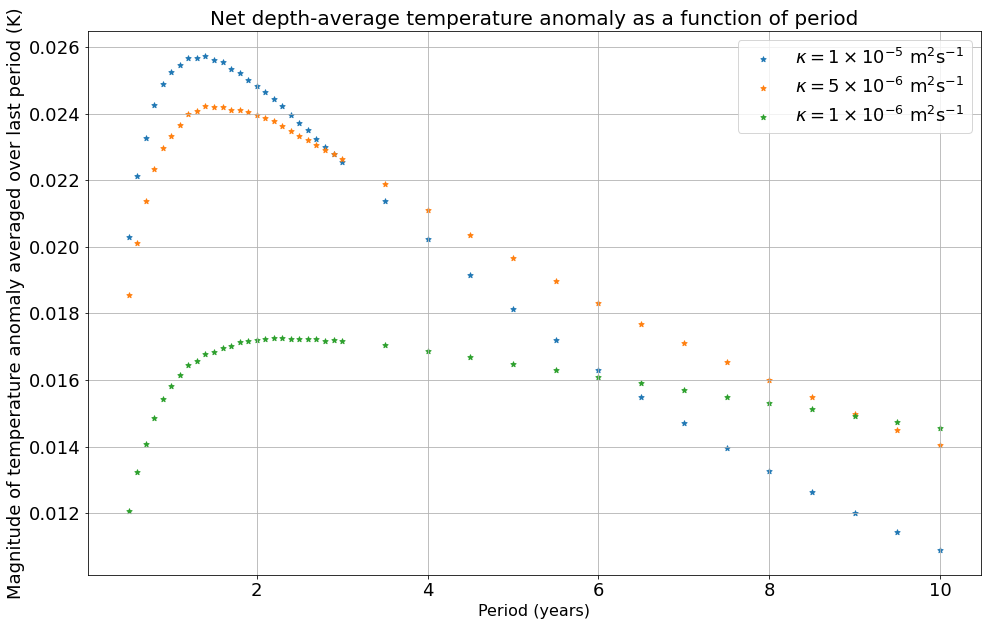

In [32]:
plt.figure(figsize=(16,10))
plt.title('Net depth-average temperature anomaly as a function of period', fontsize=20)
plt.xlabel('Period (years)', fontsize=16)
plt.ylabel('Magnitude of temperature anomaly averaged over last period (K)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.scatter(periods, np.abs(T_kappa_plus_final_distribution), s=30, marker='*', color='C0', label=r'$\kappa = 1 \times 10^{-5}$ m$^2$s$^{-1}$')
plt.scatter(periods, np.abs(T_final_distribution), s=30, marker='*', color='C1', label=r'$\kappa = 5 \times 10^{-6}$ m$^2$s$^{-1}$')
plt.scatter(periods, np.abs(T_kappa_minus_final_distribution), s=30, marker='*', color='C2', label=r'$\kappa = 1 \times 10^{-6}$ m$^2$s$^{-1}$')
plt.grid()
plt.legend(fontsize=18)
# plt.savefig('ch4_period_diffusivity_final_temp_distribution_yrs0-10.jpg', bbox_inches='tight', dpi=100)

## Seasonality and resonance

In [4]:
years = 100
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
kappa = 5e-06
mu = 1/(10 * 365 * 86400)

period = 1
Q_season_SH = 2.0 * np.sin((2 * np.pi / (period * 360)) * (t - 360/2))
T0_season_SH = 0.25 * np.sin((2 * np.pi / (period * 360)) * (t - 360/2))
Q_season_NH = 2.0 * np.sin((2 * np.pi / (period * 360)) * t)
T0_season_NH = 0.25 * np.sin((2 * np.pi / (period * 360)) * t)

control_with_seasonal_NH = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_season_NH, T0_season_NH, years)
control_with_seasonal_SH = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_season_SH, T0_season_SH, years)

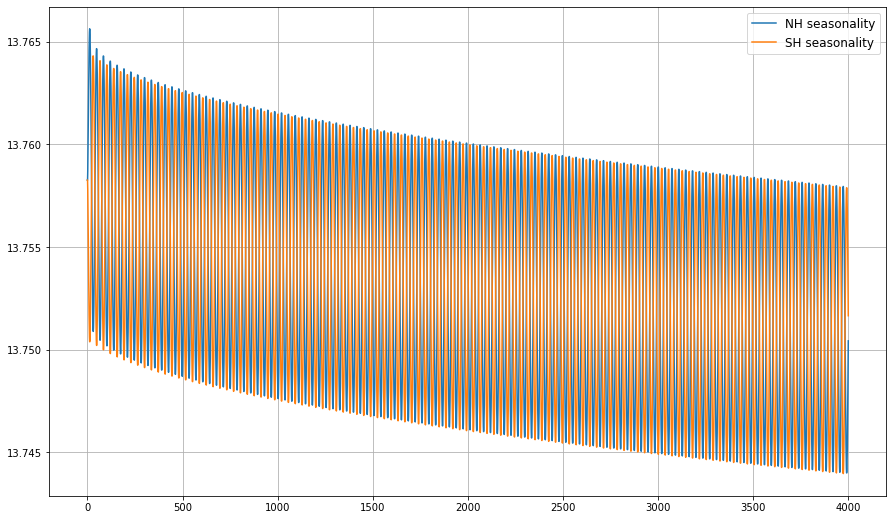

In [144]:
plt.figure(figsize=(15,9))
plt.plot(OHC(control_with_seasonal_NH)[:4000],label='NH seasonality')
plt.plot(OHC(control_with_seasonal_SH)[:4000],label='SH seasonality')
plt.grid()
plt.legend(fontsize=12)

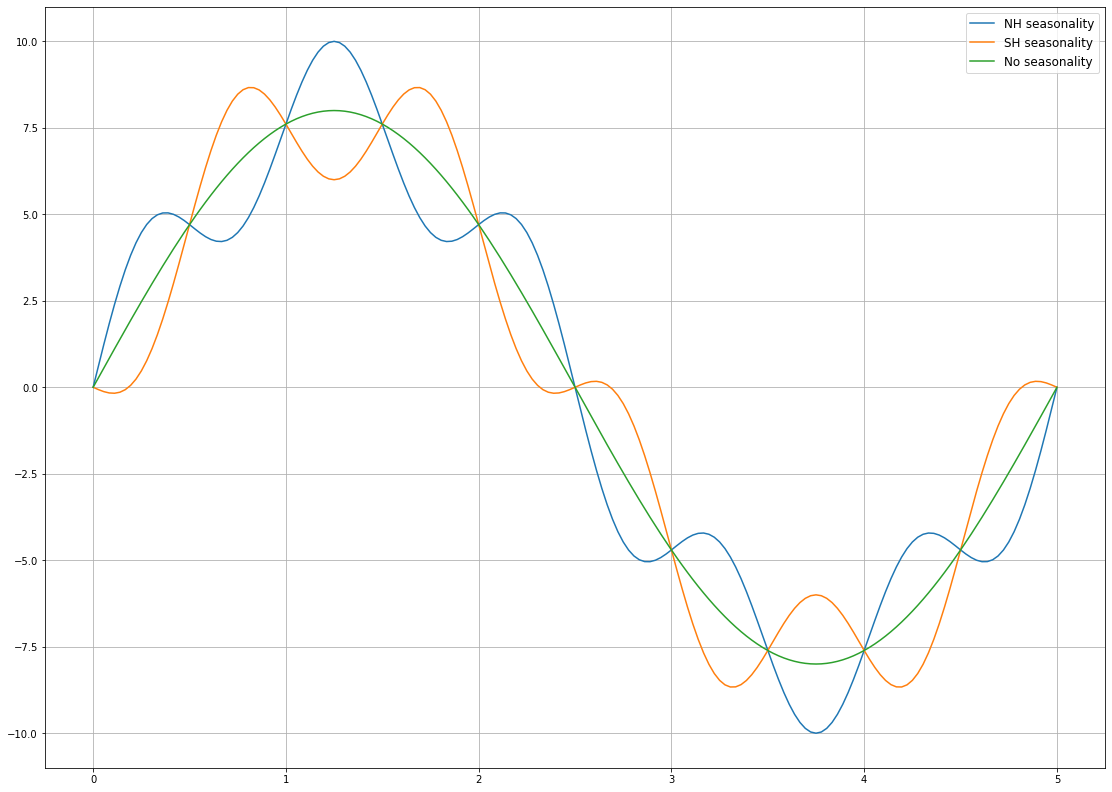

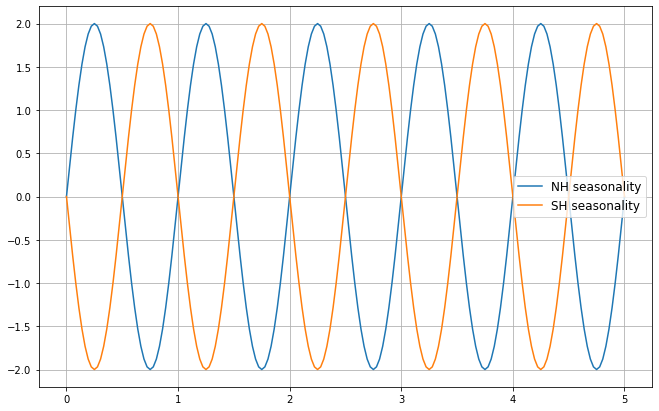

In [163]:
plt.figure(figsize=(19,14))
year = 5
plt.plot((t/360)[:year*36+1], (sin(8.0, 5)+Q_season_NH[:N+1])[:year*36+1],label='NH seasonality')
plt.plot((t/360)[:year*36+1], (sin(8.0, 5)+Q_season_SH[:N+1])[:year*36+1],label='SH seasonality')
plt.plot((t/360)[:year*36+1], sin(8.0, 5)[:year*36+1],label='No seasonality')
plt.legend()
plt.grid()
plt.legend(fontsize=12)

plt.figure(figsize=(11,7))
plt.plot((t/360)[:year*36+1], (Q_season_NH[:N+1])[:year*36+1],label='NH seasonality')
plt.plot((t/360)[:year*36+1], (Q_season_SH[:N+1])[:year*36+1],label='SH seasonality')
plt.legend()
plt.grid()
plt.legend(fontsize=12)

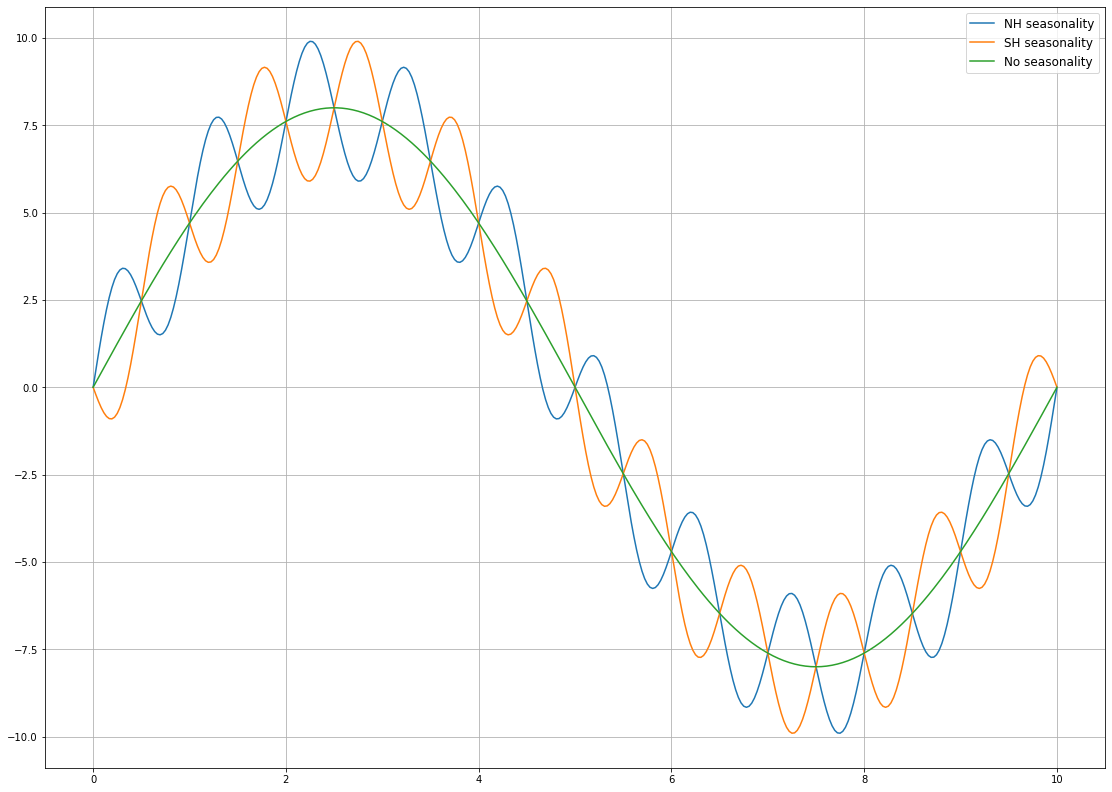

In [172]:
plt.figure(figsize=(19,14))
year = 10
Q_season_NH_10 = 2.0 * np.sin((2 * np.pi / (1 * 360)) * t)
Q_season_SH_10 = 2.0 * np.sin((2 * np.pi / (1 * 360)) * (t - 360/2))
Q_10 = sin(8.0, 10) # 8.0*np.sign(sin(8.0, 10))
plt.plot((t/360)[:year*36+1], (Q_10+Q_season_NH_10)[:year*36+1],label='NH seasonality')
plt.plot((t/360)[:year*36+1], (Q_10+Q_season_SH_10)[:year*36+1],label='SH seasonality')
plt.plot((t/360)[:year*36+1], Q_10[:year*36+1],label='No seasonality')
plt.legend()
plt.grid()
plt.legend(fontsize=12)

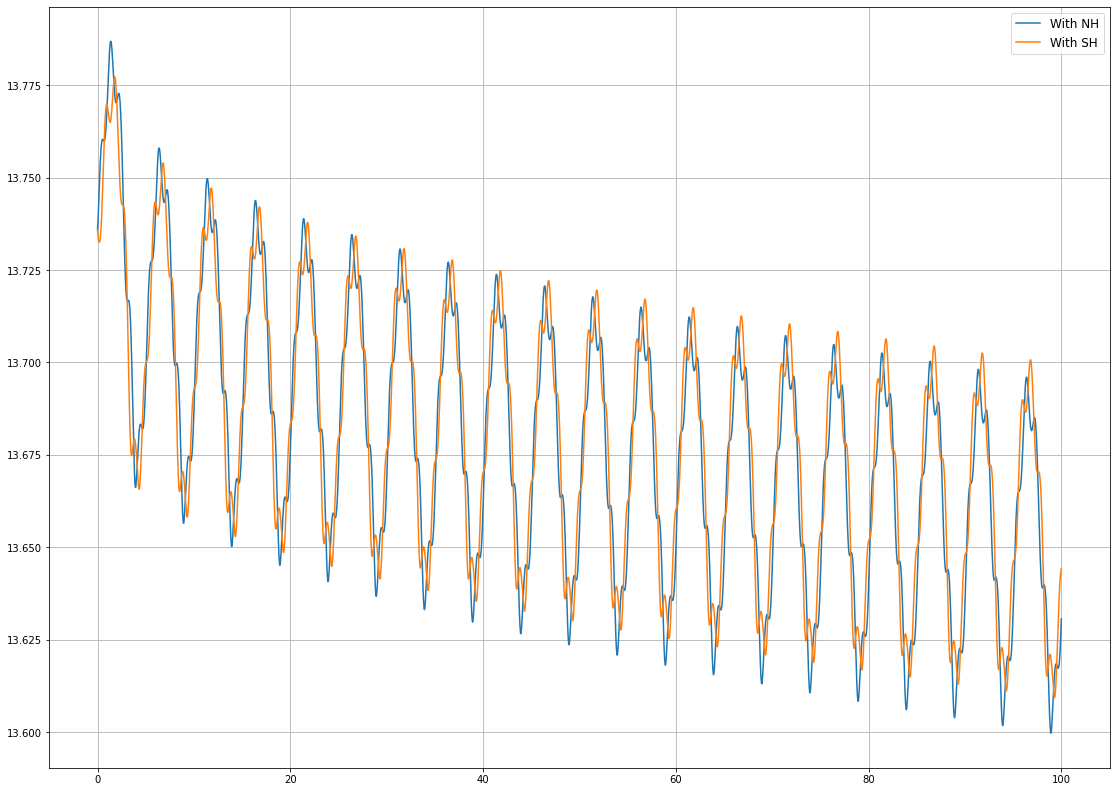

In [159]:
plt.figure(figsize=(19,14))
plt.plot(t/360, OHC(T_period5_with_season_NH) - OHC(T_period5_with_season_NH)[0] + (OHC(T_period5_with_season_NH)[0] + OHC(T_period5_with_season_SH)[0])/2,label='With NH')
plt.plot(t/360, OHC(T_period5_with_season_SH) - OHC(T_period5_with_season_SH)[0] + (OHC(T_period5_with_season_NH)[0] + OHC(T_period5_with_season_SH)[0])/2,label='With SH')
plt.grid()
plt.legend(fontsize=12)

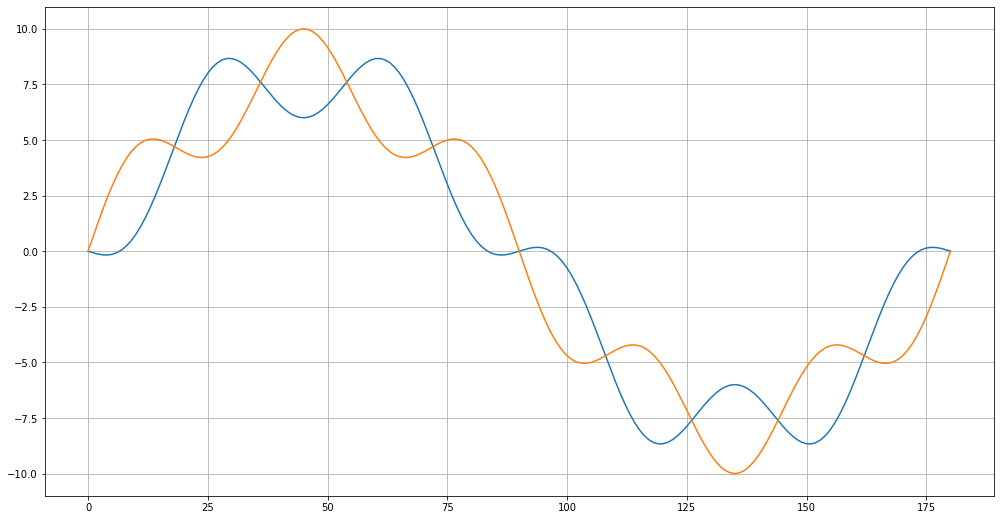

In [86]:
plt.figure(figsize=(17,9))
# plt.plot(Q_season_SH[:5*36+1])
plt.plot((Q_season_SH+sin(8, 5))[:5*36+1])
plt.plot((Q_season_NH+sin(8, 5))[:5*36+1])
plt.grid()